so i do still need to test this by running everything without colab crashing halfway through

not sure it's possible

success tbd

In [ ]:
import xml.etree.ElementTree as et
import re
import pandas as pd
import numpy as np
import seaborn as sb

##initial data preprocessing:

###safety dataset file download/clean/splitting

In [ ]:
!git clone https://github.com/duomei98/chemical-hazards.git
%cd chemical-hazards

Cloning into 'chemical-hazards'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (5/5), done.
Receiving objects: 100% (7/7), done.
remote: Total 7 (delta 0), reused 0 (delta 0), pack-reused 0
/content/chemical-hazards


In [ ]:
!wget ftp.ncbi.nlm.nih.gov/pubchem/Compound/Extras/CID-LCSS.xml.gz

--2024-07-14 22:23:54--  http://ftp.ncbi.nlm.nih.gov/pubchem/Compound/Extras/CID-LCSS.xml.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.11, 130.14.250.12, 130.14.250.13, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.11|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ftp.ncbi.nlm.nih.gov/pubchem/Compound/Extras/CID-LCSS.xml.gz [following]
--2024-07-14 22:23:54--  https://ftp.ncbi.nlm.nih.gov/pubchem/Compound/Extras/CID-LCSS.xml.gz
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 306701954 (292M) [application/x-gzip]
Saving to: ‘CID-LCSS.xml.gz’

CID-LCSS.xml.gz     100%[===================>] 292.49M  20.1MB/s    in 18s     

2024-07-14 22:24:12 (16.1 MB/s) - ‘CID-LCSS.xml.gz’ saved [306701954/306701954]



In [ ]:
!gzip -d CID-LCSS.xml.gz

In [ ]:
!python clean.py CID-LCSS.xml CID-LCSS-cleaned.xml

In [ ]:
!python split.py CID-LCSS-cleaned.xml CID-LCSS-split

###getting cids and GHS codes from the safety dataset

Based on preliminary data exploration of the overall file with vim:
- All records are of type CID
- Root node is of type Records, the file contains only record notes within the root

In [ ]:
tree = et.parse('CID-LCSS-split-0.xml')
root = tree.getroot()

In [ ]:
root.tag

'{http://pubchem.ncbi.nlm.nih.gov/pug_view}Records'

We can observe that the namespace is `http://pubchem.ncbi.nlm.nih.gov/pug_view`, this is the only namespace according to the XML schema file (i think). For now, all we want is the GHS information and the CID.

In [ ]:
#exploration of what sections there can be per record
ns = {'pc':'http://pubchem.ncbi.nlm.nih.gov/pug_view'} #dictionary for the namespace
secnames = set()
for head in root.findall('.//pc:TOCHeading', ns):
  secnames.add(head.text)
secnames

{'2D Structure',
 'Acceptable Daily Intakes',
 'Additional Considerations',
 'Allowable Tolerances',
 'Autoignition Temperature',
 'Boiling Point',
 'CAS',
 'CSL Reaction Information',
 'Cancer Sites',
 'Carcinogen Classification',
 'Chemical Dangers',
 'Cleanup Methods',
 'Cleanup and Disposal',
 'Corrosivity',
 'Critical Temperature & Pressure',
 'Decomposition',
 'Density',
 'Depositor-Supplied Synonyms',
 'Disposal Methods',
 'Effects of Long Term Exposure',
 'Effects of Short Term Exposure',
 'Evidence for Carcinogenicity',
 'Explosion Hazards',
 'Explosive Limits and Potential',
 'Exposure Limits',
 'Exposure Routes',
 'Fire Hazards',
 'Fire Potential',
 'First Aid',
 'Flammability and Explosivity',
 'Flammable Limits',
 'Flash Point',
 'GHS Classification',
 'Hazardous Reactivities & Incompatibilities',
 'Hazards Summary',
 'Health and Symptoms',
 'Highly Hazardous Substance',
 'Human Toxicity Values',
 'Identifiers',
 'Immediately Dangerous to Life or Health (IDLH)',
 'InChI',


In [ ]:
#ns = {'pc':'http://pubchem.ncbi.nlm.nih.gov/pug_view'} #dictionary for the namespace
tsv = open('cid-ghs.tsv', 'w', encoding='utf-8')
tsv.write('CID\tghs-all\n')#,density,fp,mp,bp');

# writing CID, GHS to a tsv (not csv as the GHS will be a comma separated list)
allghs = set();
for i in range(9):
  print('CID-LCSS-split-'+str(i)+'.xml')
  tree = et.parse('CID-LCSS-split-'+str(i)+'.xml')
  root = tree.getroot()
  for child in root:
    line = child.find('pc:RecordNumber', ns).text
    add = False; #only write if we can find the GHS information
    for sec in child.findall('.//pc:Section', ns):
      if sec.find('pc:TOCHeading', ns).text == 'GHS Classification':
        add = True;
        ghs = set();
        for string in sec.findall('.//pc:String', ns):
          ghs.update(re.findall('H[2-4][0-9]{2}', string.text))
        allghs.update(ghs)
    if add:
      line += '\t' + (str(ghs) if len(ghs) > 0 else '') + '\n'
      tsv.write(line);
tsv.close()

CID-LCSS-split-0.xml
CID-LCSS-split-1.xml
CID-LCSS-split-2.xml
CID-LCSS-split-3.xml
CID-LCSS-split-4.xml
CID-LCSS-split-5.xml
CID-LCSS-split-6.xml
CID-LCSS-split-7.xml
CID-LCSS-split-8.xml


In [ ]:
tsvdf=pd.read_csv('cid-ghs.tsv', sep='\t')
cids = ''
for cid in tsvdf['CID']:
  cids += str(cid) + '\n'
out = open('cid.txt', 'w', encoding='utf-8')
out.write(cids)
out.close()
# using the list of CIDs to download a xml of chemical summaries from pubchem, we obtain pubchem-cid-summaries.xml

Pubchem allows downloads of the chemical information summaries for a list of CIDs (Pubchem's own chemical id system), but the results are only stored for 8 hours. You should be able to obtain the same results by uploading `cids.txt` as a list, but for convenience we have uploaded our resulting xml (not a csv because chemical names often have commas in them) to Dropbox.

In [ ]:
del tree
del root

###smiles data download/splitting/parsing

In [ ]:
!wget https://www.dropbox.com/scl/fi/9n8zxgim61wop7y4jir4k/pubchem-cid-summaries.xml?rlkey=6fvao8q0fkuhd2p2xxcwrydx0&st=afjwbise&dl=0
!mv pubchem-cid-summaries.xml?rlkey=6fvao8q0fkuhd2p2xxcwrydx0 pubchem-cid-summaries.xml

--2024-07-14 22:33:26--  https://www.dropbox.com/scl/fi/9n8zxgim61wop7y4jir4k/pubchem-cid-summaries.xml?rlkey=6fvao8q0fkuhd2p2xxcwrydx0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uca5e5f175f19e73b470cbc640db.dl.dropboxusercontent.com/cd/0/inline/CWsnP-rSjXl4pMCo5uKDL6H4ksTJ3FBkgnCBytk4J5jGb7s7fK-CAxEqCKVcZGiCam_pEWLROFqqcYfSWyGUd0uwE1kkhaRxtATukJH1p0td2q9cLryCa7gun0urnAD1tK_ylyYPaDCt_lUV2IbxB2dc/file# [following]
--2024-07-14 22:33:27--  https://uca5e5f175f19e73b470cbc640db.dl.dropboxusercontent.com/cd/0/inline/CWsnP-rSjXl4pMCo5uKDL6H4ksTJ3FBkgnCBytk4J5jGb7s7fK-CAxEqCKVcZGiCam_pEWLROFqqcYfSWyGUd0uwE1kkhaRxtATukJH1p0td2q9cLryCa7gun0urnAD1tK_ylyYPaDCt_lUV2IbxB2dc/file
Resolving uca5e5f175f19e73b470cbc640db.dl.dropboxusercontent.com (uca5e5f175f19e73b470cbc640db.dl.dropboxusercontent.com)... 162.125

In [ ]:
# the goal is to obtain the canonical SMILES from the xml
# unfortunately it is too large of a file
# so we're splitting again
# yeehaw
r = open('pubchem-cid-summaries.xml', 'r', buffering=16777216, encoding='utf-8') #the file should be clear of encoding errors.
w = open('pubchem-cid-summaries-split-0.xml', 'w', buffering=16777216, encoding='utf-8')
head = '<compound>';
lines = 0;
filenum = 0;
filelen = 10000000

for line in r:
  w.write(line)
  lines += 1
  if lines >= filelen and line.find('</row>') != -1:
    w.write('</compound>')
    w.close()
    filenum +=1
    lines = 0;
    w = open('pubchem-cid-summaries-split-'+str(filenum)+'.xml', 'w', buffering=16777216, encoding='utf-8')
    w.write(head)
w.close()
r.close()

In [ ]:
# then we write the cid and iso smiles to another tsv
# by taking a peek at the xml file we can observe there is no namespace
# yippee

smilestsv = open('cid-smiles.tsv', 'w', encoding='utf-8')
smilestsv.write('CID\tSMILES\n')

for i in range(4):
  print('pubchem-cid-summaries-split-'+str(i)+'.xml')
  tree = et.parse('pubchem-cid-summaries-split-'+str(i)+'.xml')
  root = tree.getroot()
  for child in root:
    smilestsv.write(child.find('cid').text + '\t' + child.find('canonicalsmiles').text + '\n')

smilestsv.close()
#thing = pd.read_xml('pubchem-cid-summaries.xml');

pubchem-cid-summaries-split-0.xml
pubchem-cid-summaries-split-1.xml
pubchem-cid-summaries-split-2.xml
pubchem-cid-summaries-split-3.xml


In [ ]:
del root
del tree

###combining the datasets

In [ ]:
#map of pictograms to their hazard codes
pict2code = {
    'explosive': {'H200', 'H201', 'H202', 'H203', 'H204','H209','H210','H211','H240','H241'},
    'flammable': {'H205', 'H206', 'H207','H208','H220','H221','H222','H223','H224','H225','H226','H227','H228','H229','H230','H231','H232','H240','H241','H242','H250','H251','H252','H260','H261','H282','H283'},
    'oxidizer': {'H270','H271','H272'},
    'pressurized': {'H280','H281','H282','H283','H284'},
    'corrosive': {'H290','H314','H318'},
    'toxic': {'H300','H301','H310','H311','H330','H331'},
    'irritant': {'H204','H302','H312','H315','H317','H319','H332','H335','H336'},
    'health hazard': {'H304','H305','H334','H340','H341','H350','H351','H360','H361','H370','H371','H372','H373'},
    'environmental hazard': {'H400','H410','H411','H420'}
}

In [ ]:
#first, reducing the ghs codes to a one-hot encoding of the pictograms:
#       explosive, flammable, oxidizer, pressurized (??), corrosive, toxic, irritant, health hazard, environmental hazard
ghsdf=tsvdf
ghsdf['ghs-all'] = ghsdf['ghs-all'].apply(lambda x: '{\'\'}' if pd.isna(x) else x)
for pict in pict2code:
  print(pict)
  ghsdf[pict]=ghsdf['ghs-all'].apply(lambda x: 1 if eval(str(x)) & pict2code[pict] else 0)

explosive
flammable
oxidizer
pressurized
corrosive
toxic
irritant
health hazard
environmental hazard


In [ ]:
smilesdf=pd.read_csv('cid-smiles.tsv', sep='\t')
overalldf = pd.merge(smilesdf, ghsdf, on='CID')
overalldf = overalldf.drop(columns=['ghs-all'])

##data exploration

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# note: data is already one-hot encoded
overalldf

,CID,SMILES,explosive,flammable,oxidizer,pressurized,corrosive,toxic,irritant,health hazard,environmental hazard
0,4,CC(CN)O,0,0,0,0,1,0,1,0,0
1,6,C1=CC(=C(C=C1[N+](=O)[O-])[N+](=O)[O-])Cl,0,0,0,0,1,1,1,1,1
2,8,CCC(C)(C(C(=O)O)O)O,0,0,0,0,0,0,1,0,0
3,11,C(CCl)Cl,0,1,0,0,0,1,1,1,1
4,12,C1=C(C=C(C(=C1O)O)O)O,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
222473,171391221,C1=CC2=C(C(=C(C=C2C=C1NC(=O)NC3=CC4=CC(=C(C(=C...,0,0,0,0,0,0,0,0,0
222474,171391230,CC1=C(C2=C(C=C1)N=C(S2)C3=CC=C(C=C3)NC4=NC(=NC...,0,0,0,0,0,0,0,0,0
222475,171391231,CC1=CC=C(C=C1)S(=O)(=O)NC2=C3C(=CC(=C2)S(=O)(=...,0,0,0,0,0,0,1,0,0
222476,171391236,CC1=CC=CC=C1OC2=CC=CC=C2N=NC3=C(C4=C(C=C(C=C4C...,0,0,0,0,0,0,0,0,0


In [ ]:
# check if there are missing values in any columns
# chatgpt prompt: how to check if observations are missing values
# False: indicates no missing values yay

print(overalldf.isnull().values.any())

False


In [ ]:
# basic description of dataframe

print(overalldf.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222478 entries, 0 to 222477
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   CID                   222478 non-null  int64 
 1   SMILES                222478 non-null  object
 2   explosive             222478 non-null  int64 
 3   flammable             222478 non-null  int64 
 4   oxidizer              222478 non-null  int64 
 5   pressurized           222478 non-null  int64 
 6   corrosive             222478 non-null  int64 
 7   toxic                 222478 non-null  int64 
 8   irritant              222478 non-null  int64 
 9   health hazard         222478 non-null  int64 
 10  environmental hazard  222478 non-null  int64 
dtypes: int64(10), object(1)
memory usage: 18.7+ MB
None


In [ ]:
ghs = (overalldf.drop(columns=['SMILES','CID']))
ghs

,explosive,flammable,oxidizer,pressurized,corrosive,toxic,irritant,health hazard,environmental hazard
0,0,0,0,0,1,0,1,0,0
1,0,0,0,0,1,1,1,1,1
2,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,1,1,1,1
4,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
222473,0,0,0,0,0,0,0,0,0
222474,0,0,0,0,0,0,0,0,0
222475,0,0,0,0,0,0,1,0,0
222476,0,0,0,0,0,0,0,0,0


In [ ]:
# check distribution of hazard types
for column in ghs:
    print(f"Non-zero counts for '{column}':", overalldf[column].sum())

Non-zero counts for 'explosive': 213
Non-zero counts for 'flammable': 13350
Non-zero counts for 'oxidizer': 438
Non-zero counts for 'pressurized': 297
Non-zero counts for 'corrosive': 35075
Non-zero counts for 'toxic': 15711
Non-zero counts for 'irritant': 187902
Non-zero counts for 'health hazard': 16404
Non-zero counts for 'environmental hazard': 18346


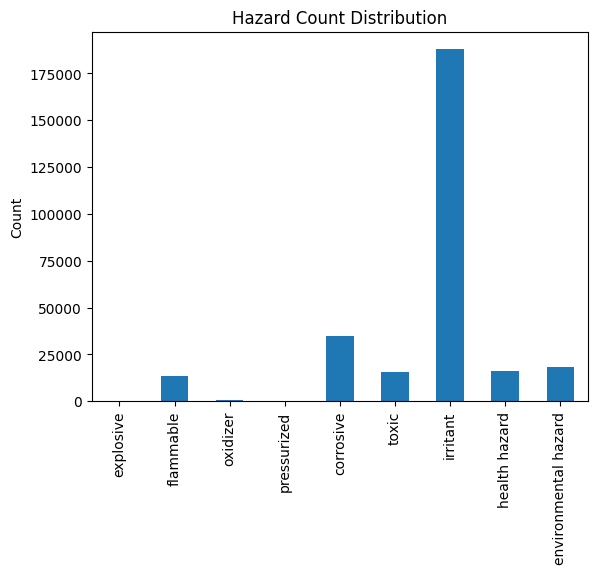

In [ ]:
# plot distribution
overalldf[ghs.columns].sum().plot(kind='bar')
plt.ylabel('Count')
plt.title('Hazard Count Distribution')
plt.show()

<Axes: >

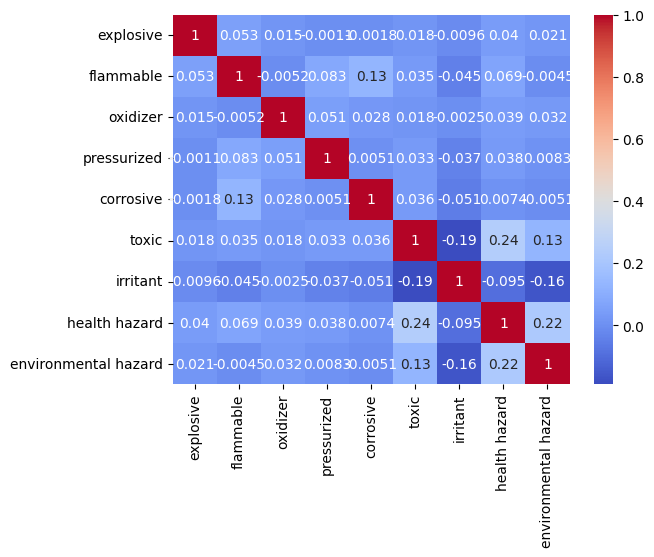

In [ ]:
# corr data + heatmap
corr = ghs.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
# from the data, there is not much corr between different ghs types